In [1]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

# -------------------------------------------------------
# 1. Dataset Class
# -------------------------------------------------------

class BrainTumorDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        self.classes = sorted(os.listdir(root_dir))
        self.image_paths = []
        self.labels = []

        for idx, cls in enumerate(self.classes):
            class_folder = os.path.join(root_dir, cls)
            if not os.path.isdir(class_folder):
                continue
            for img_name in os.listdir(class_folder):
                img_path = os.path.join(class_folder, img_name)
                if img_name.lower().endswith((".png", ".jpg", ".jpeg")):
                    self.image_paths.append(img_path)
                    self.labels.append(idx)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        img_path = self.image_paths[index]
        label = self.labels[index]

        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label



In [2]:
# -------------------------------------------------------
# 2. Load Dataset
# -------------------------------------------------------

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])

dataset_path = "data/Training"   # change to Testing if needed
dataset = BrainTumorDataset(dataset_path, transform=transform)

print(f"Total images: {len(dataset)}")
print("Classes:", dataset.classes)



Total images: 5712
Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])


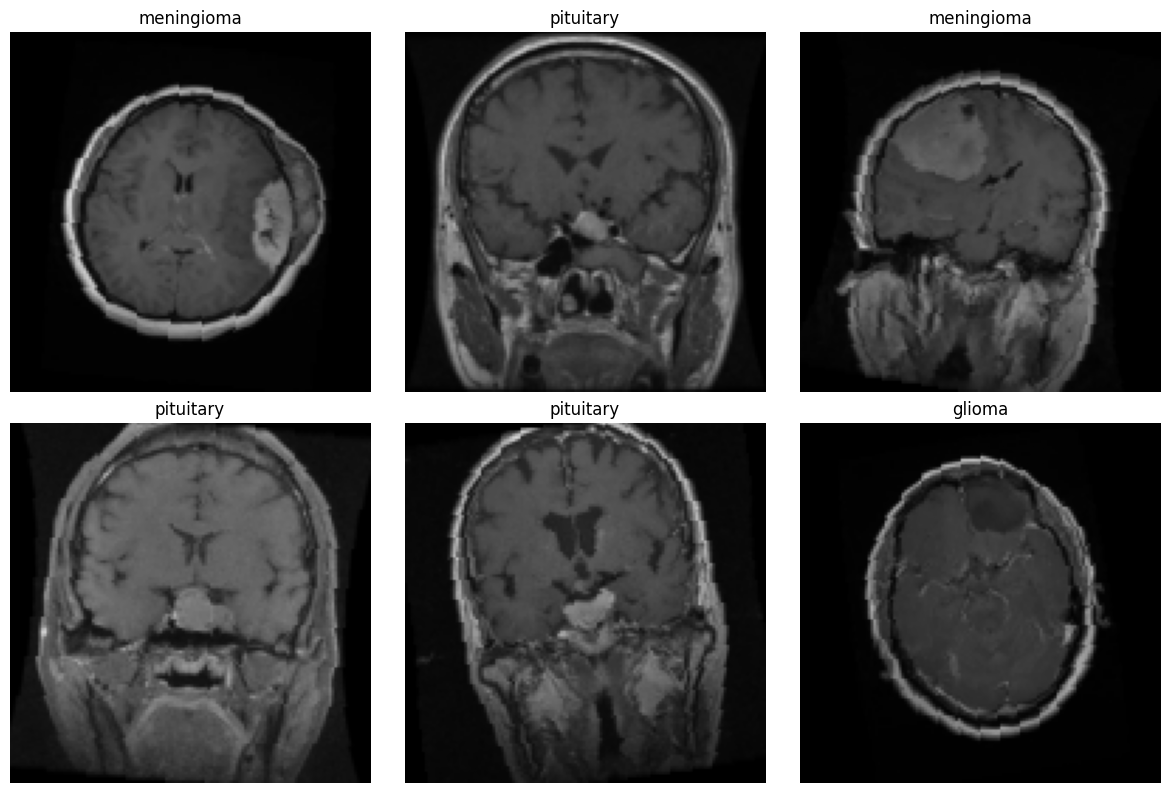

In [3]:
# -------------------------------------------------------
# 3. Display Random Images
# -------------------------------------------------------

def show_random_images(dataset, num_images=6):
    plt.figure(figsize=(12, 8))
    for i in range(num_images):
        idx = random.randint(0, len(dataset)-1)
        image, label = dataset[idx]

        # Convert tensor → numpy image
        print(image.shape)
        image_np = image.permute(1,2,0).numpy()

        plt.subplot(2, 3, i+1)
        plt.imshow(image_np)
        plt.title(dataset.classes[label])
        plt.axis("off")

    plt.tight_layout()
    plt.show()

show_random_images(dataset, num_images=6)

In [4]:
trainloader = DataLoader(dataset, batch_size=8, shuffle=True)

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN_network(nn.Module):
    def __init__(self):
        super(CNN_network, self).__init__()
        
        # 1. Convolutional Block
        # Reminder: If your MRI data is grayscale, change the '3' below to '1'.
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) 
        self.dropout = nn.Dropout(0.25)
        
        # 2. Fully Connected Block
        # CORRECTED INPUT SIZE: 16 * 64 * 64 = 65,536 (Matches the 128x128 data)
        self.fc1 = nn.Linear(16 * 64 * 64, 128) # Input 65536 -> 128 hidden neurons
        self.fc2 = nn.Linear(128, 4)            # 128 -> 4 classes

    def forward(self, x):
        # Convolution and Pooling
        x = self.pool(F.relu(self.conv1(x)))
        
        # Flattening: x.size(0) preserves the batch size (which is 8)
        x = x.view(x.size(0), -1) 
        
        # Fully Connected Layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

⬇️ Start Training with Gradient Descent...

Epoch 1 Completed — Average Loss: 0.7346
Epoch 2 Completed — Average Loss: 0.4731
Epoch 3 Completed — Average Loss: 0.3996
Epoch 4 Completed — Average Loss: 0.3433
Epoch 5 Completed — Average Loss: 0.3072
Epoch 6 Completed — Average Loss: 0.2653
Epoch 7 Completed — Average Loss: 0.2457
Epoch 8 Completed — Average Loss: 0.2269
Epoch 9 Completed — Average Loss: 0.2097
Epoch 10 Completed — Average Loss: 0.1869

✅ Finished Training


📉 GRADIENT DESCENT EXPLANATION:
- Each point is the loss after a batch.
- The optimizer adjusts weights to move downhill.
- The smoothed curve shows the overall descent.

⚡ LR EXPLANATION:
- LR controls how big each step of gradient descent is.
- High LR = bigger jumps; Low LR = smaller, precise steps.


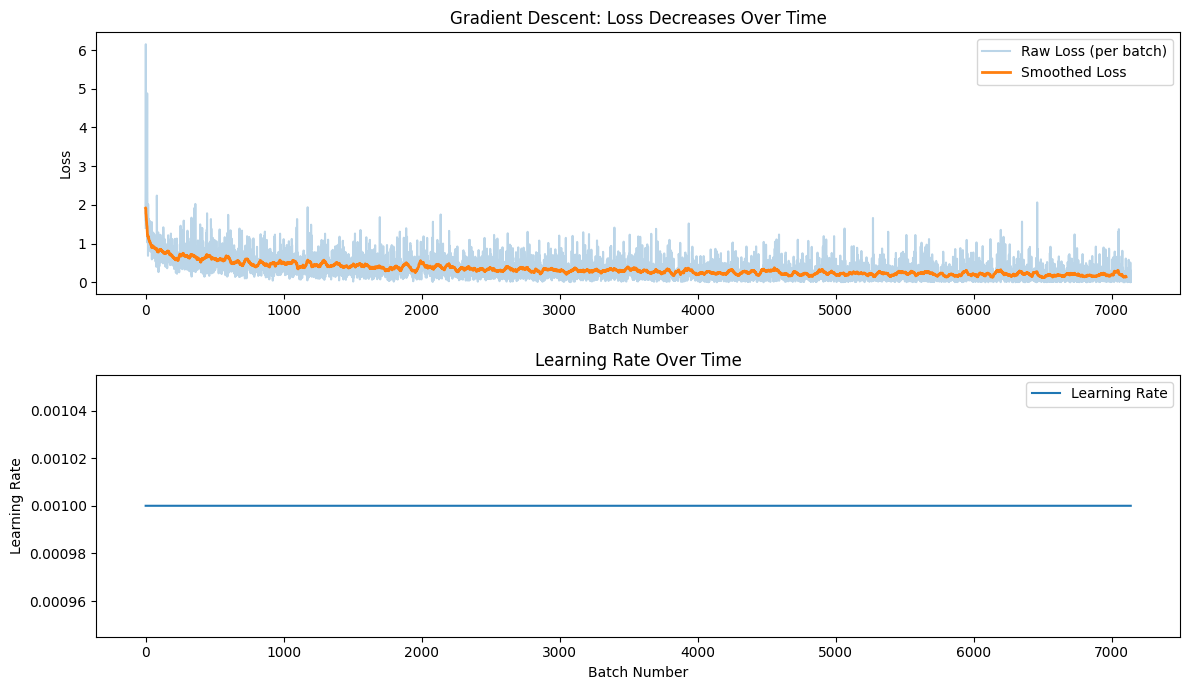

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np


# -----------------------------------------------------------------------
# Improved loss plotting function that explains gradient descent behavior
# -----------------------------------------------------------------------
def plot_training_progress(loss_history, lr_history):
    """
    Shows:
    - Raw loss per batch (noisy curve)
    - Smoothed loss curve (true descent trend)
    - Learning rate per batch
    """

    if not loss_history:
        print("No loss data recorded.")
        return

    # Convert to numpy for easier processing
    loss_history = np.array(loss_history)
    lr_history = np.array(lr_history)

    # Smooth loss curve – moving average
    window = max(5, len(loss_history) // 200)
    smooth_loss = np.convolve(loss_history, np.ones(window)/window, mode='valid')

    plt.figure(figsize=(12, 7))

    # -----------------------------
    # Plot 1 — Loss curve (Gradient Descent visualization)
    # -----------------------------
    plt.subplot(2, 1, 1)
    plt.plot(loss_history, alpha=0.3, label="Raw Loss (per batch)")
    plt.plot(np.arange(len(smooth_loss)), smooth_loss, linewidth=2, label="Smoothed Loss")

    plt.title("Gradient Descent: Loss Decreases Over Time")
    plt.xlabel("Batch Number")
    plt.ylabel("Loss")
    plt.legend()

    # Explanation for beginners
    print("\n📉 GRADIENT DESCENT EXPLANATION:")
    print("- Each point is the loss after a batch.")
    print("- The optimizer adjusts weights to move downhill.")
    print("- The smoothed curve shows the overall descent.")

    # -----------------------------
    # Plot 2 — Learning rate curve
    # -----------------------------
    plt.subplot(2, 1, 2)
    plt.plot(lr_history, label="Learning Rate")
    plt.title("Learning Rate Over Time")
    plt.xlabel("Batch Number")
    plt.ylabel("Learning Rate")
    plt.legend()

    print("\n⚡ LR EXPLANATION:")
    print("- LR controls how big each step of gradient descent is.")
    print("- High LR = bigger jumps; Low LR = smaller, precise steps.")

    plt.tight_layout()
    plt.show()


# -----------------------------------------------------------------------
# TRAINING CODE — rewritten to clearly explain gradient descent
# -----------------------------------------------------------------------

criterion = nn.CrossEntropyLoss()
model = CNN_network()

# Adam controls the learning rate dynamically each batch
optimizer = optim.Adam(model.parameters(), lr=0.001)

device = torch.device("cpu")
model.to(device)

loss_history = []
lr_history = []  # Track learning rate each batch (Adam changes internally)

print("⬇️ Start Training with Gradient Descent...\n")

for epoch in range(10):
    running_loss = 0.0
    model.train()

    for i, (images, labels) in enumerate(trainloader):

        images, labels = images.to(device), labels.to(device)

        # 1. RESET GRADIENTS
        optimizer.zero_grad()

        # 2. FORWARD PASS — model makes prediction
        outputs = model(images)

        # 3. COMPUTE LOSS — measures how wrong predictions are
        loss = criterion(outputs, labels)

        # Save the loss
        loss_history.append(loss.item())

        # Save current LR for visualization
        current_lr = optimizer.param_groups[0]['lr']
        lr_history.append(current_lr)

        # 4. BACKWARD PASS — compute gradients for all parameters
        loss.backward()

        # 5. UPDATE WEIGHTS — gradient descent step
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1} Completed — Average Loss: {running_loss/len(trainloader):.4f}")

print("\n✅ Finished Training\n")

plot_training_progress(loss_history, lr_history)

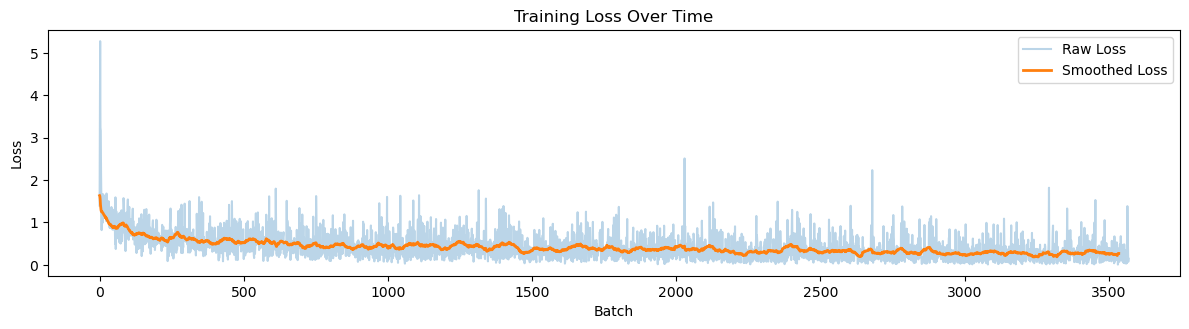

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_loss(loss_history, lr_history=None, batches_per_epoch=None):
    """
    Plot improved training curves:
    - Raw loss curve
    - Smoothed loss curve (moving average)
    - Optional learning rate schedule
    - Optional epoch separators
    """

    if not loss_history:
        print("No loss data recorded.")
        return

    loss_history = np.array(loss_history)

    # ---- SMOOTH THE LOSS CURVE (moving average) ----
    window = max(5, len(loss_history) // 100)   # auto window size
    smooth_loss = np.convolve(loss_history, np.ones(window)/window, mode='valid')

    plt.figure(figsize=(12, 6))

    # ---- PLOT 1: LOSS OVER TIME ----
    plt.subplot(2, 1, 1)
    plt.plot(loss_history, alpha=0.3, label="Raw Loss")
    plt.plot(np.arange(len(smooth_loss)), smooth_loss, label="Smoothed Loss", linewidth=2)

    # Draw epoch lines
    if batches_per_epoch is not None:
        for e in range(1, len(loss_history) // batches_per_epoch):
            x = e * batches_per_epoch
            plt.axvline(x, color='gray', linestyle='--', alpha=0.4)
            plt.text(x, max(loss_history)*0.97, f"Epoch {e}", rotation=90, alpha=0.5)

    plt.title("Training Loss Over Time")
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.legend()

    # ---- PLOT 2: LEARNING RATE SCHEDULE ----
    if lr_history is not None:
        plt.subplot(2, 1, 2)
        plt.plot(lr_history, label="Learning Rate", color='green')
        plt.title("Learning Rate per Batch")
        plt.xlabel("Batch")
        plt.ylabel("Learning Rate")
        plt.legend()

    plt.tight_layout()
    plt.show()
# Visualize the loss after training
plot_loss(loss_history)